In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Pascal Voc dataset

In [2]:
!wget -O "data.tar" "http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar" 

--2021-07-15 14:36:16--  http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar [following]
--2021-07-15 14:36:16--  https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/octet-stream]
Saving to: ‘data.tar’

data.tar            100%[===================>]   1.86G  19.0MB/s    in 74s     

2021-07-15 14:37:30 (25.8 MB/s) - ‘data.tar’ saved [1999639040/1999639040]



In [3]:
!tar -xvf "data.tar" -C "." &> /dev/null #[run this cell to extract tar files]
!rm data.tar

In [4]:
from glob import glob
import PIL
import pandas
import matplotlib.pyplot as plt

def getlist(traintext):
  traintext=traintext.readlines()
  for i,text in enumerate(traintext):
    traintext[i]=text.split('\n')[0]

  x_list = ('/content/VOCdevkit/VOC2012/JPEGImages/'+pandas.Series(traintext)+'.jpg').tolist()
  y_list = ('/content/VOCdevkit/VOC2012/SegmentationClass/'+pandas.Series(traintext)+'.png').tolist()
  return x_list,y_list

traintext=open('/content/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt','r')
trainvaltext=open('/content/VOCdevkit/VOC2012/ImageSets/Segmentation/trainval.txt','r')
valtext=open('/content/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt','r')
train_list,train_y_list=getlist(traintext)
train_val_list,train_val_y_list=getlist(trainvaltext)
val_list,val_y_list=getlist(valtext)
print(len(train_list),len(train_y_list))
print(len(train_val_list),len(train_val_y_list))
print(len(val_list),len(val_y_list))

1464 1464
2913 2913
1449 1449


In [5]:
import numpy as np

VOC_CLASSES = np.array([
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
])


VOC_COLORMAP = np.array([
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
])
VOC_CLASSES=np.expand_dims(VOC_CLASSES,axis=-1)
# print(VOC_CLASSES.shape,VOC_COLORMAP.shape)
selected=np.concatenate([VOC_CLASSES,VOC_COLORMAP],axis=-1)
np.int32(selected[:,1:])

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0],
       [  0,  64, 128]], dtype=int32)

In [6]:
import tensorflow as tf
def load_one(path,y_path,selected,dimension=(512,512)):
  x=PIL.Image.open(path).convert('RGB')
  x=x.resize(dimension)
  y=PIL.Image.open(y_path).convert('RGB')
  y=y.resize(dimension)
  y=np.array(y)
  selected=np.int32(selected[:,1:])
  mask=np.zeros_like(y,dtype='int64')
  mask=mask[:,:,0]
  for i in range(selected.shape[0]):
    mask=mask+((tf.reduce_sum((y==selected[i])*1,axis=-1).numpy()==3)*(i+1))
  mask=mask+((mask==0)*1)
  mask=mask-1
  return x,mask

(array([ 0,  9, 12]), array(['background', 'chair', 'dog'], dtype='<U12'))

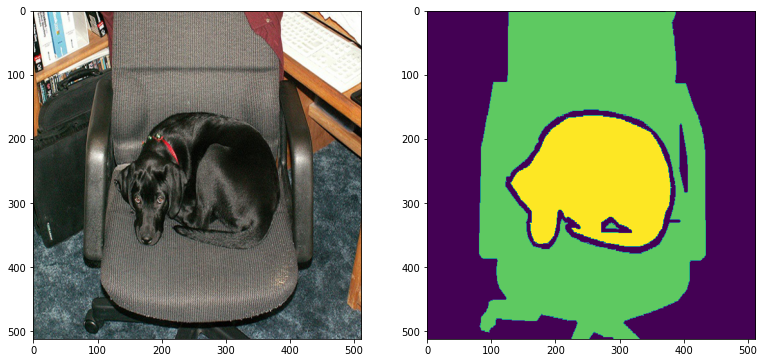

In [7]:
import numpy as np

img,mask=load_one(train_list[2],train_y_list[2],selected,dimension=(512,512))

fig=plt.figure(figsize=(20,8))
fig.add_subplot(1,3,1)
plt.imshow(img)
fig.add_subplot(1,3,2)
plt.imshow(mask)
np.unique(mask),VOC_CLASSES[np.unique(mask),0]

In [8]:
from tensorflow.keras.utils import Sequence
import math
import numpy as np
import random
from albumentations import HorizontalFlip, GridDistortion, OpticalDistortion, ChannelShuffle, CenterCrop, Crop, Rotate
import albumentations as A

class Datagenerator(Sequence):
  def __init__(self,x_list,y_list,batch_size=16,augment=False,shuffle=False,dimension=(512,512),log=False):
    self.x_list=x_list
    self.y_list=y_list
    self.batch_size=batch_size
    self.augment=augment
    self.shuffle=shuffle
    self.dimension=dimension
    self.log=log
    self.transform = A.Compose([
        A.RandomCrop(width=dimension[0], height=dimension[1]),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.ChannelShuffle(p=0.1)
    ])

  def __len__(self):
    return math.ceil(len(self.x_list)/self.batch_size)
  def __getitem__(self,idx):
    x_batch_list,y_batch_list=self.x_list[(idx*self.batch_size):((idx+1)*self.batch_size)],self.y_list[(idx*self.batch_size):((idx+1)*self.batch_size)]
    # print(len(x_batch_list),len(y_batch_list))
    # x_batch=np.array()
    for i in range(len(x_batch_list)):
      
      #data augmentation
      if self.augment:
        img,mask=load_one(x_batch_list[i],y_batch_list[i],selected,dimension=(self.dimension[0]+60,self.dimension[1]+60))
        img=np.array(img)
        mask=np.array(mask)
        mask=np.expand_dims(mask,axis=-1)
        # aug =HorizontalFlip(p=0.7)
        # augmented =aug(image=img,mask=mask)
        # img=augmented['image']
        # mask=augmented['mask']
        # aug = Rotate(limit=45, p=0.7)
        # augmented = aug(image=img, mask=mask)
        # img = augmented["image"]
        # mask = augmented["mask"]
        # aug = ChannelShuffle(p=0.5)
        # augmented = aug(image=img, mask=mask)
        # img = augmented["image"]
        # mask = augmented["mask"]
        augmented = self.transform(image=img, mask=mask)
        img = augmented["image"]
        mask = augmented["mask"]
      else:
        img,mask=load_one(x_batch_list[i],y_batch_list[i],selected,dimension=self.dimension)
        img=np.array(img)
        mask=np.array(mask)
        mask=np.expand_dims(mask,axis=-1)
      if i==0:
        x_batch=np.array(img)
        x_batch=np.expand_dims(x_batch,axis=0)
        y_batch=np.array(mask)
        y_batch=np.expand_dims(y_batch,axis=0)
        # y_batch=np.expand_dims(y_batch,axis=-1)
        # print(x_batch.shape)
      else:
        img=np.expand_dims(img,axis=0)
        mask=np.expand_dims(mask,axis=0)
        x_batch=np.concatenate([x_batch,img],axis=0)
        y_batch=np.concatenate([y_batch,mask],axis=0)
    # print("x_batch",x_batch.shape,"y_batch",y_batch.shape)
    x_batch=x_batch/255
    y_batch=tf.keras.utils.to_categorical(y_batch,num_classes=VOC_CLASSES.shape[0])
    return x_batch,y_batch


  def on_epoch_end(self):
    if self.log:
      print("logging")
      logpreds()
      
    if self.shuffle==True:
      seed=int(random.random()*100)
      random.seed(seed)
      random.shuffle(self.x_list)
      random.seed(seed)
      random.shuffle(self.y_list)

In [9]:
traingen=Datagenerator(train_list,train_y_list,augment=True,shuffle=True)
# valgen=Datagenerator(val_list,val_y_list,augment=False,shuffle=False)
# testgen=Datagenerator(test_list,test_y_list,augment=False,shuffle=False)

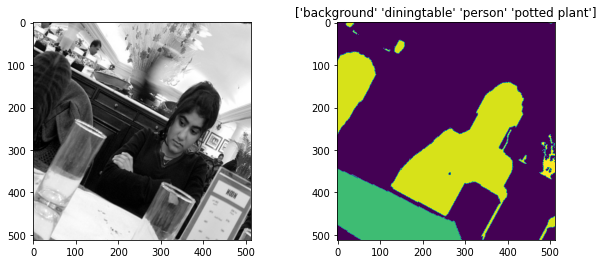

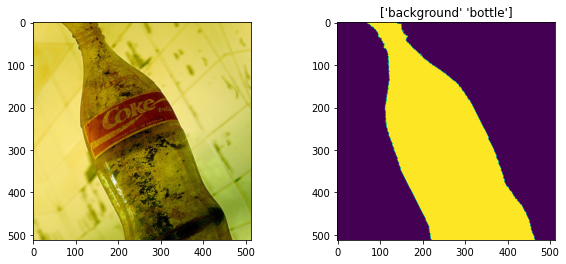

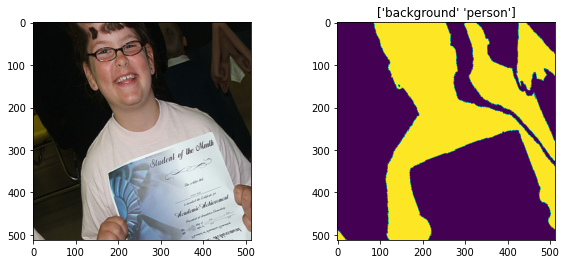

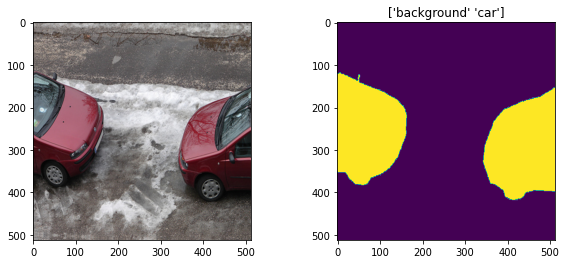

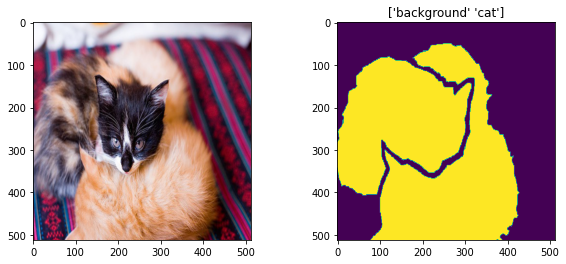

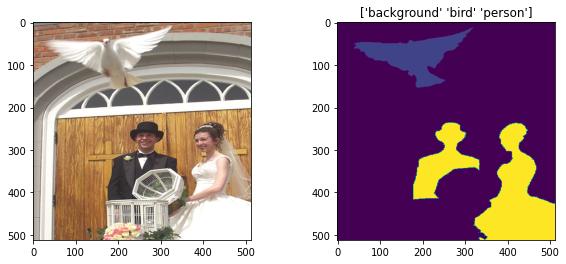

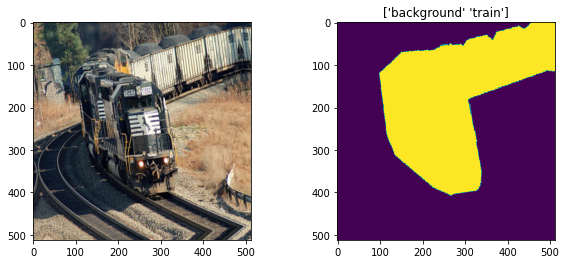

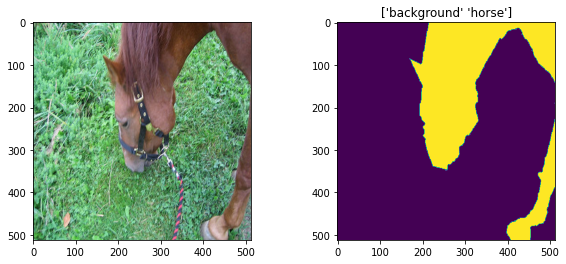

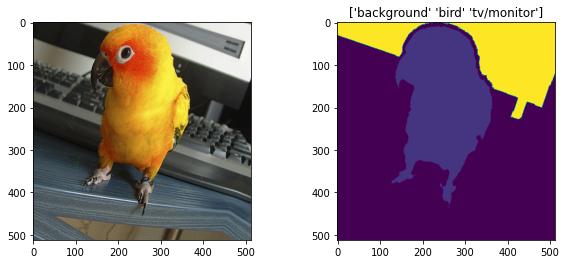

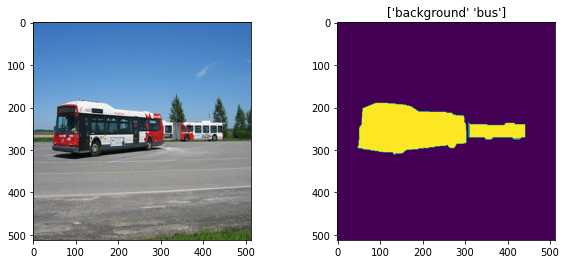

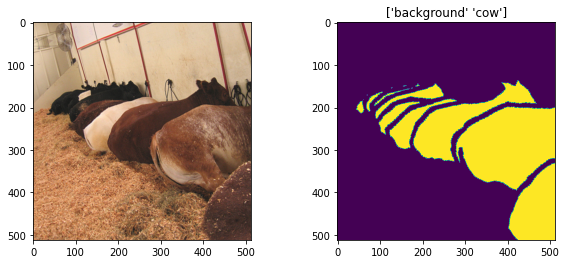

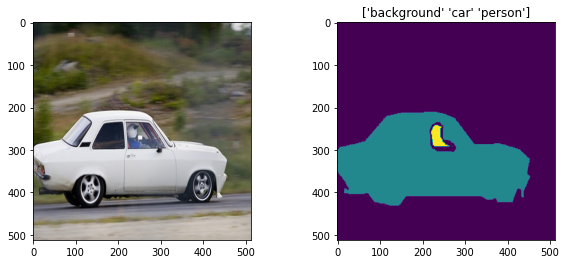

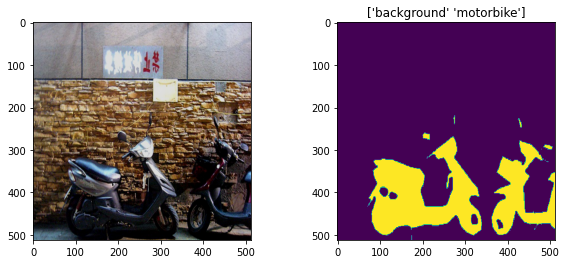

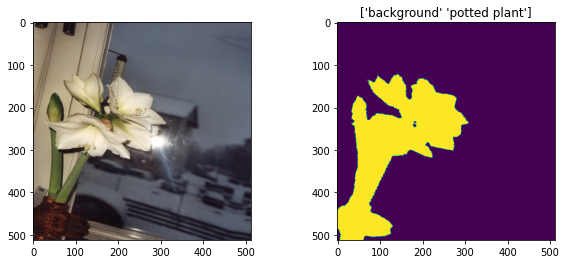

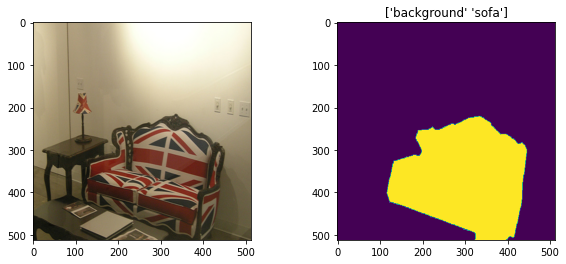

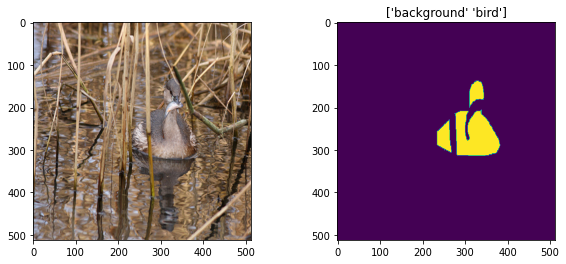

In [10]:
import matplotlib.pyplot as plt
traingen.on_epoch_end()
x,y=traingen.__getitem__(0)
y=np.argmax(y,axis=-1)
for i in range(x.shape[0]):
  fig=plt.figure(figsize=(10,4))
  fig.add_subplot(1,2,1)
  plt.imshow(x[i,...])
  fig.add_subplot(1,2,2)
  plt.title(str(VOC_CLASSES[np.unique(y[i,:,:]),0]))
  plt.imshow(y[i,:,:])

#Deeplab v3+ Model

In [11]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Reshape, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import layers,Model
from tensorflow.keras.applications import ResNet50
import tensorflow as tf

def squeeze_and_excite(input,rate=8):
  #channel attention shape
  c_a_shape=(1,1,input.shape[-1])
  x=GlobalAveragePooling2D()(input)
  x=Reshape(c_a_shape)(x)
  x=Dense(input.shape[-1]//rate,activation="relu",kernel_initializer="he_normal",use_bias=False)(x)
  x=Dense(input.shape[-1],activation="sigmoid",kernel_initializer="he_normal",use_bias=False)(x)
  # x=tf.expand_dims(x,axis=-2)
  # x=tf.expand_dims(x,axis=-2)
  # print(input.shape)
  # print(x.shape)
  out=input*x
  return out



def ASPP(input):
  x=AveragePooling2D((input.shape[1],input.shape[2]))(input)
  # print(x.shape)
  y1=Conv2D(256,1,padding='same',use_bias=False)(x)
  y1=layers.BatchNormalization()(y1)
  y1=Activation("relu")(y1)
  y1 = UpSampling2D((input.shape[1],input.shape[2]), interpolation="bilinear")(y1)

  y2=Conv2D(256,1,padding="same",use_bias=False)(input)
  y2=layers.BatchNormalization()(y2)
  y2=Activation("relu")(y2)

  y3=Conv2D(256,3,padding="same",use_bias=False,dilation_rate=6)(input)
  y3=layers.BatchNormalization()(y3)
  y3=Activation("relu")(y3)

  y4=Conv2D(256,3,padding="same",use_bias=False,dilation_rate=12)(input)
  y4=layers.BatchNormalization()(y4)
  y4=Activation("relu")(y4)

  y5=Conv2D(256,3,padding="same",use_bias=False,dilation_rate=18)(input)
  y5=layers.BatchNormalization()(y5)
  y5=Activation("relu")(y5)

  y=Concatenate()([y1,y2,y3,y4,y5])
  
  y=Conv2D(256,1,padding="same",use_bias=False)(y)
  y=layers.BatchNormalization()(y)
  y=Activation("relu")(y)
  return y

def deeplab(out_channels=1):
  x_input=Input(shape=(512,512,3))
  #encoder
  x=ResNet50(include_top=False,weights="imagenet",input_tensor=x_input)
  image_features=x.get_layer("conv4_block6_out").output
  # print(image_features.shape)
  x_a=ASPP(image_features)
  x_a=UpSampling2D((4,4),interpolation="bilinear")(x_a)
  # print(x_a.shape)

  x_b=x.get_layer("conv2_block2_out").output
  x_b=Conv2D(48,1,padding="same",use_bias=False)(x_b)
  x_b=layers.BatchNormalization()(x_b)
  x_b=Activation("relu")(x_b)

  x=Concatenate()([x_a,x_b])
  x=squeeze_and_excite(x)

  #decoder
  x=Conv2D(256,3,padding="same",use_bias=False)(x)
  x=layers.BatchNormalization()(x)
  x=Activation("relu")(x)

  x=Conv2D(256,3,padding="same",use_bias=False)(x)
  x=layers.BatchNormalization()(x)
  x=Activation("relu")(x)
  x=squeeze_and_excite(x)

  x=UpSampling2D((4,4),interpolation="bilinear")(x)
  x=Conv2D(out_channels,1,activation="softmax")(x)
  # print(x.shape)

  model=Model(x_input,x)
  # model.summary()
  return model
# deeplab().summary()

#loss and dice metric

In [12]:
import tensorflow as tf
import tensorflow.keras.backend as K
def advanced_dice_score(y_true,y_pred,backend=False):

  y_true=tf.cast(y_true,dtype="float32")
  # tf.print(y_true.shape[1]*y_true.shape[2],y_true.shape[3])
  # y_true=K.reshape(y_true,(4,512*512,21))
  y_pred=tf.cast(y_pred,dtype="float32")
  # y_pred=K.reshape(y_pred,(4,512*512,21))
  
  true_channels=(tf.reduce_sum(tf.reduce_sum(y_true,axis=-2),axis=-2)!=0)
  # intersection=tf.reduce_sum(tf.multiply(y_true,y_pred),axis=-2)
  intersection=tf.reduce_sum(tf.reduce_sum(tf.multiply(y_true,y_pred),axis=-2),axis=-2)
  # union=tf.reduce_sum(y_true+y_pred,axis=-2)
  union=tf.reduce_sum(tf.reduce_sum(y_true+y_pred,axis=-2),axis=-2)
  # print('U',union.shape,"I",intersection.shape)
  true_dice=(2*intersection[true_channels]+1e-9)/(union[true_channels]+1e-9)
  # print(intersection[true_channels].shape)
  true_dice=tf.reduce_mean(true_dice,axis=0)

  if backend:
    false_channels=tf.math.logical_not(true_channels)
    intersection=intersection[false_channels]
    # print(intersection)
    union=union[false_channels]
    # print(union)
    # print('U',union.shape,"I",intersection.shape)
    error_dice=(2*intersection+1e-9)/(union+1e-9)
    error_dice=tf.reduce_mean(error_dice,axis=0)
    return true_dice,error_dice
  else:
    return true_dice

In [13]:
advanced_dice_score(tf.keras.utils.to_categorical(y[1:2,...],num_classes=VOC_CLASSES.shape[0]),tf.keras.utils.to_categorical(y[6:7,...],num_classes=VOC_CLASSES.shape[0]),backend=True)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.38590768>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.94736844>)

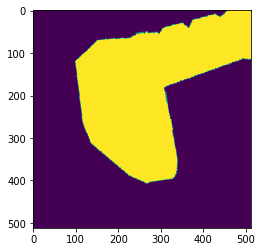

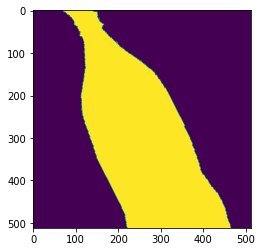

In [14]:
plt.figure()
plt.imshow(np.argmax(tf.keras.utils.to_categorical(y[6,...],num_classes=VOC_CLASSES.shape[0]),axis=-1))
plt.figure()
plt.imshow(np.argmax(tf.keras.utils.to_categorical(y[1,...],num_classes=VOC_CLASSES.shape[0]),axis=-1))

In [15]:
from tensorflow import keras

def dice_cce_loss(y_true,y_pred,use_cce=True,use_dice=True):
  loss=0
  if use_cce:
    cce_loss=tf.reduce_mean(keras.losses.categorical_crossentropy(y_true,y_pred))
    loss+=cce_loss
  if use_dice:
    true_dice,false_dice=advanced_dice_score(y_true,y_pred,backend=True)
    t_dice_loss=1-true_dice
    f_dice_loss=(1-false_dice)*2
    # loss+=t_dice_loss
    loss+=t_dice_loss+f_dice_loss
  return loss

In [17]:
# print(tf.keras.utils.to_categorical(y,num_classes=VOC_CLASSES.shape[0]).shape)
dice_cce_loss(tf.keras.utils.to_categorical(y[1:5,...],num_classes=VOC_CLASSES.shape[0]),tf.keras.utils.to_categorical(y[5:9,...],num_classes=VOC_CLASSES.shape[0]))

<tf.Tensor: shape=(), dtype=float32, numpy=9.737116>

#Logging predictings

In [18]:
class_labels ={(i):name[0] for i,name in enumerate(VOC_CLASSES)}
labels_class={(name[0]):i for i,name in enumerate(VOC_CLASSES)}
class_labels

{0: 'background',
 1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'potted plant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tv/monitor'}

In [19]:
def logpreds():
  img,mask=valgen.__getitem__(0)
  pred=model.predict(img)
  pred=np.uint8((pred>0.5)*1)
  mask=np.argmax(mask,axis=-1)
  pred=np.argmax(pred,axis=-1)
  for i in range(img.shape[0]):

    caption_str=str(','.join(VOC_CLASSES[np.unique(pred[i,...]),0]))

    mask_img = wandb.Image(img[i,...], masks={
      "predictions": {
        "mask_data": pred[i,:,:],
        "class_labels": class_labels
      },
      "ground_truth": {
        "mask_data": mask[i,:,:],
        "class_labels": class_labels
      }

    },caption=caption_str)
    wandb.log({f"predictions{i+1}": mask_img,})

In [20]:
# wandb.init(project='car segmentation', entity='anujpanthri')
# logpreds()

#Training

In [21]:
!pip install wandb &> /dev/null
import wandb
from wandb.keras import WandbCallback

In [22]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15457131507802087270, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11344216064
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8812228780670809062
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [23]:
# model=deeplab(21)
# model.compile(loss=dice_cce_loss,optimizer=keras.optimizers.Adam(0.0001),metrics=[advanced_dice_score])

94773248/94765736 [==============================] - 1s 0us/step


In [46]:
model=keras.models.load_model("/content/drive/MyDrive/human_segmention/pascal_unet.h5",compile=False)
model.compile(loss=dice_cce_loss,optimizer=keras.optimizers.Adam(0.0001),metrics=[advanced_dice_score])

In [36]:
traingen=Datagenerator(train_list,train_y_list,augment=True,shuffle=True,batch_size=4,log=True,dimension=(512,512))
trainvalgen=Datagenerator(train_val_list[2000:],train_val_y_list[2000:],augment=True,shuffle=True,batch_size=4,log=True,dimension=(512,512))
valgen=Datagenerator(val_list[:100],val_y_list[:100],augment=False,shuffle=False,batch_size=4,dimension=(512,512))

In [37]:
wandb.init(project='car segmentation', entity='anujpanthri')

config = wandb.config
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',patience=3),
           keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/human_segmention/pascal_more_unet.h5",monitor='val_loss',save_best_only=True),
           WandbCallback()]

model.fit(traingen,validation_data=valgen,epochs=10,callbacks=callbacks)

epoch,8
loss,2.70456
advanced_dice_score,0.69682
val_loss,3.2097
val_advanced_dice_score,0.57724
_runtime,7709
_timestamp,1626367885
_step,40
best_val_loss,2.95845
best_epoch,5


epoch,▁▂▃▄▅▅▆▇█
loss,█▅▄▃▂▂▂▁▁
advanced_dice_score,▁▄▅▆▆▇▇██
val_loss,█▅▁▁▃▁▂▁▂
val_advanced_dice_score,▁▃▇▇▇████
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


Epoch 1/10
366/366 [==============================] - 851s 2s/step - loss: 2.6061 - advanced_dice_score: 0.7252 - val_loss: 2.8255 - val_advanced_dice_score: 0.6362


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


logging
Epoch 2/10


KeyboardInterrupt: ignored

In [34]:
# model.save("/content/drive/MyDrive/human_segmention/pascal_unet.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [45]:
model.evaluate(valgen)## my model

25/25 [==============================] - 33s 1s/step - loss: 2.8242 - advanced_dice_score: 0.6357


[2.82420015335083, 0.6356536746025085]

#Results

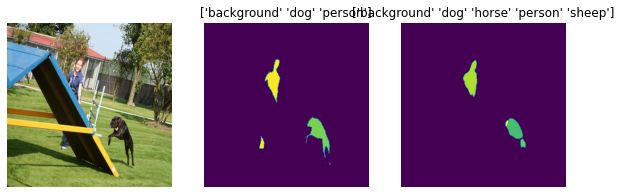

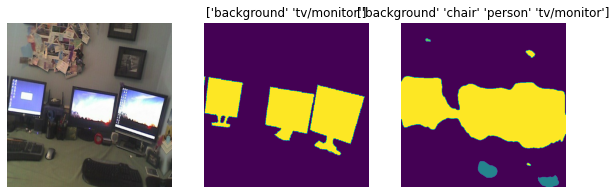

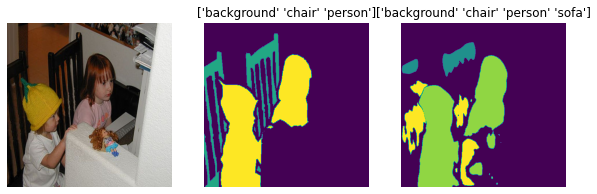

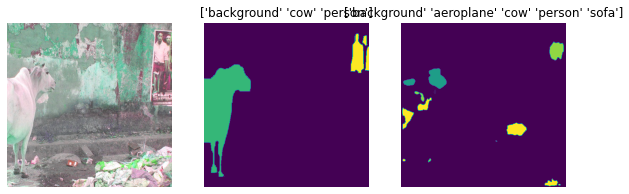

In [38]:
img,mask=traingen.__getitem__(0)
mask=np.argmax(mask,axis=-1)
for i in range(img.shape[0]):
  fig=plt.figure(figsize=(10,4))
  fig.add_subplot(1,3,1)
  plt.axis("off")
  plt.imshow(img[i,...])
  pred=model.predict(img[i:i+1,...])
  pred=(pred>0.5)*1
  pred=np.argmax(pred,axis=-1)
  fig.add_subplot(1,3,2)
  plt.axis("off")
  plt.title(str(VOC_CLASSES[np.unique(mask[i,:,:]),0]))
  plt.imshow(mask[i,:,:])
  fig.add_subplot(1,3,3)
  plt.axis("off")
  plt.title(str(VOC_CLASSES[np.unique(pred[0,:,:]),0]))
  plt.imshow(pred[0,:,:])
  # fig.add_subplot(1,3,3)
  # plt.axis("off")
  # plt.imshow(img[i,...]*pred[0,:,:,:])

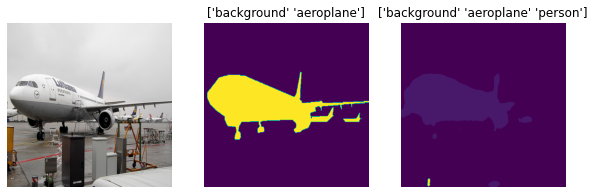

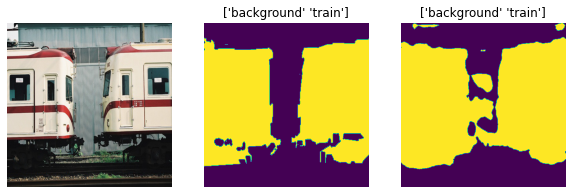

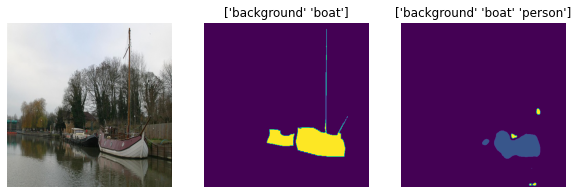

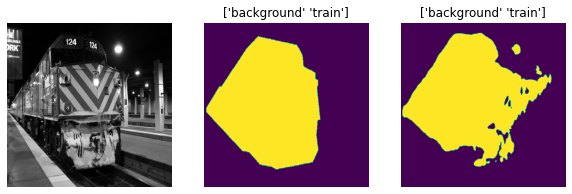

In [43]:
img,mask=valgen.__getitem__(0)
pred=model.predict(img)
pred=(pred>0.5)*1
pred=np.argmax(pred,axis=-1)
mask=np.argmax(mask,axis=-1)
for i in range(img.shape[0]):
  fig=plt.figure(figsize=(10,4))
  fig.add_subplot(1,3,1)
  plt.axis("off")
  plt.imshow(img[i,...])
  fig.add_subplot(1,3,2)
  plt.axis("off")
  plt.title(str(VOC_CLASSES[np.unique(mask[i,:,:]),0]))
  plt.imshow(mask[i,:,:])
  fig.add_subplot(1,3,3)
  plt.axis("off")
  plt.title(str(VOC_CLASSES[np.unique(pred[i,:,:]),0]))
  plt.imshow(pred[i,:,:])
  # fig.add_subplot(1,3,3)
  # plt.axis("off")
  # plt.imshow(img[i,...]*pred[0,:,:,:])

In [40]:
import PIL
import matplotlib.pyplot as plt
import numpy as np

def show(imglist):
  batch=[]
  for path in imglist:
    img=PIL.Image.open(path)
    img=img.resize((512,512))
    img=img.convert("RGB")
    img=np.array(img)
    img=np.expand_dims(img,axis=0)
    img=img/255
    batch.append(img)
  batch=np.array(batch)
  batch=np.squeeze(batch,axis=1)
  print(batch.shape)
  pred=model.predict(batch)
  pred=(pred>0.5)*1
  pred=np.argmax(pred,axis=-1)
  ###############################keep
  # keep=(pred==labels_class['person'])*1
  keep=(pred==labels_class['car'])*1
  # pred=pred*keep
  ###############################keep end
  for i in range(pred.shape[0]):
    fig=plt.figure(figsize=(15,10))
    fig.add_subplot(1,4,1)
    plt.axis("off")
    plt.imshow(batch[i,...])

    fig.add_subplot(1,4,2)
    plt.axis("off")
    plt.title(str(VOC_CLASSES[np.unique(pred[i,:,:]),0]))
    plt.imshow(pred[i,:,:])

   
    fig.add_subplot(1,4,3)
    plt.axis("off")
    plt.title(str(VOC_CLASSES[np.unique(pred[i,:,:]*keep[i,...]),0]))
    plt.imshow(pred[i,:,:]*keep[i,...])

    # pred=(pred>0.5)*1
    fig.add_subplot(1,4,4)
    plt.axis("off")
    # plt.imshow(img[0,...])
    plt.imshow(batch[i,...]*np.expand_dims((pred[i,:,:]*keep[i,...]>0.5)*1,axis=-1))

(1, 512, 512, 3)


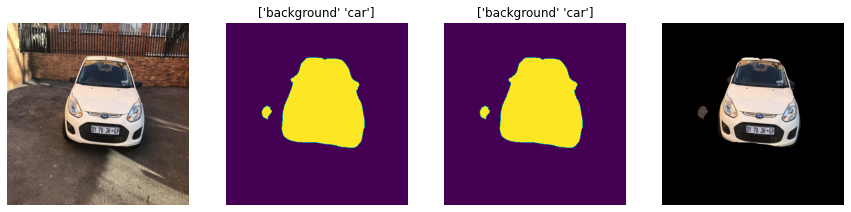

In [50]:
show(['view1.jpeg'])

(4, 512, 512, 3)


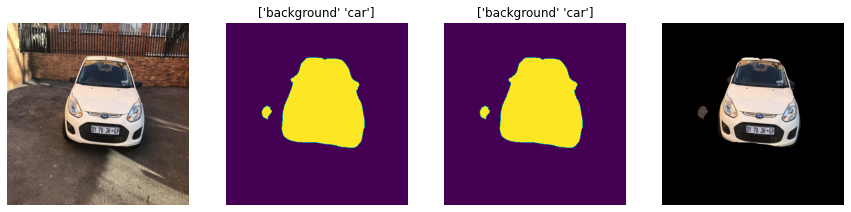

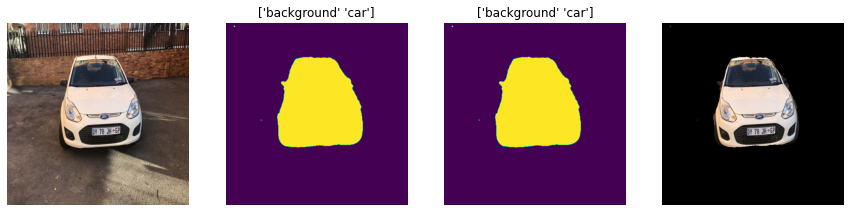

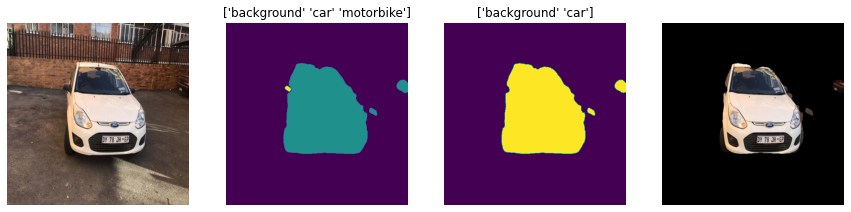

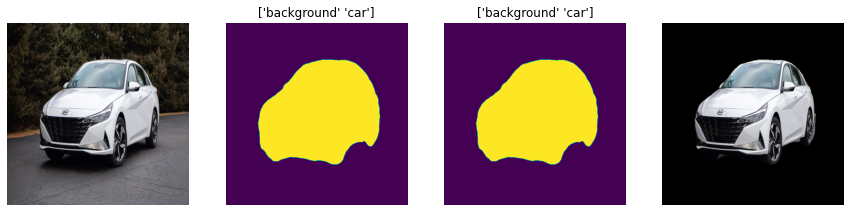

In [48]:
show(['view1.jpeg','view2.jpeg','view3.jpeg','car.jpg'])